# Take-Home Case Instructions



One of our e-commerce portfolio companies has hired a new CEO, and the CEO has asked for our help. She has provided the attached data set from their CRM and wants to understand what this pipeline opportunity data means. Definitions for key pipeline fields are included in the definitions tab.



Please analyze the data and answer the following questions:

- What are the three conclusions you would mention to the CEO? Use the questions below to guide your thinking:

    - How would you describe the health of new logos (new business) vs. existing customers (existing businesses)?

    - How has growth of key metrics (e.g., number of opportunities, ARR) changed over time?

    - How does average ARR and win rate change by state?

    - Are there any seasonality trends in the data?

    - How does conversion rate (i.e., closed won / (closed won + closed lost)) change by lead source?

    - Please forecast full year 2024 closed-won revenue. To what extent can you forecast future bookings? What assumptions are required to build an appropriate forecast?

    - Are there any anomalies or data hygiene flags?

    - What additional data would you want to round out your analyses?



#### Deliverables

1. 3-5 slides on your conclusions. Slides should focus on:

     - Key insights

     - Forecasted 2024 revenue and assumptions

     - Potential next steps (i.e., key questions, additional analyses)

2. Excel summary table on key trends -- note summary tables should leverage formulas, not pivot tables.

3. Python script with additional exploratory data analysis (if relevant) & model to forecast 2024 bookings with appropriate comments and notes.

# Definitions

Here are definitions for the fields commonly found in Salesforce pipeline opportunities:



1. **18 Digit Opportunity ID**: A unique identifier for the opportunity in Salesforce, used to track each sales deal. Salesforce uses an 18-digit case-insensitive identifier for API access, making it easier to manage unique records.



2. **Account ID**: The unique identifier for the account associated with the opportunity. An account in Salesforce represents a company or organization involved in business dealings.



3. **Parent Account ID**: This refers to the unique identifier of the parent account, if the account in question is part of a larger corporate hierarchy. This field helps in managing account hierarchies.



4. **Created Date**: The date when the opportunity record was first created in Salesforce. This helps track when the sales opportunity initially entered the pipeline.



5. **Last Modified Date**: The date when the opportunity was last updated. It reflects the most recent change made to the record, whether by a user or an automated process.



6. **Close Date**: The date when the opportunity is expected to close. In sales forecasting, this is a critical date, used to project when the deal is likely to be finalized.



7. **Type**: The classification of the opportunity, which may represent different types of sales processes (e.g., New Business, Renewal, Upsell, etc.).



8. **Stage**: Represents the current step in the sales process for this opportunity. Stages are used to track the progress of the deal, such as Prospecting, Negotiation, Closed Won, Closed Lost, etc.



9. **Opportunity ARR (Annual Recurring Revenue)**: Refers to the total amount of recurring revenue expected from the opportunity on an annual basis. This is commonly used for subscription-based products and services to measure the revenue over a year.



10. **Billing State/Province**: The state or province where the billing address for the account is located. This can be important for tax purposes or geographic sales reporting.



11. **Install Subtype**: A specific categorization of the product or service installation type. This may refer to different implementation options or technical configurations being sold to the customer.



12. **Lead Source**: This refers to the origin of the opportunity, such as Marketing Campaign, Web Inquiry, Referral, Cold Call, etc. It tracks how the lead first entered the pipeline.



13. **Subscription Level Type**: Defines the type or level of subscription being purchased. It may represent different tiers of service or product offerings, such as Basic, Premium, or Enterprise subscription levels.

# Import libraries and load data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import zscore
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error


import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Load the data
file_path = 'Crisil_Take_Home Pipeline Assesment_RA-Data Science.xlsx'
excel_data = pd.ExcelFile(file_path)

# Load the data from the excel file
pipeline_data = excel_data.parse('Pipeline Data')

pipeline_data.head()

,18 Digit Opportunity ID,Account ID,Parent Account ID,Created Date,Last Modified Date,Close Date,Type,Stage,Opportunity ARR,Billing State/Province,Install Subtype,Lead Source,Subscription Level Type
0,0066S000014lj8ZQAQ,0016S00003HgjuE,0016S00003J9AWv,2022-12-12,2024-01-08,2023-01-03,New Business,No Renewal,2400.0,Arizona,Single Unit,Website,Pro
1,0066S000014loIgQAI,0016S00003HgpIM,0016S00003J99D6,2022-12-13,2023-11-01,2023-01-03,New Business,No Renewal,2400.0,New York,Single Unit,Website,Pro
2,0066S000015onphQAA,0016S00003J97xb,0016S00003J97zX,2023-01-03,2023-11-01,2023-01-03,New Business,Stalled Resell Needed,2000.0,Florida,Single Unit,Eventup,Pro
3,0066S000015ooudQAA,0016S00003J98yL,0016S00003J9931,2023-01-03,2024-05-22,2023-01-03,New Business,No Renewal,2000.0,California,Single Unit,Website,Pro
4,0066S000015oxUaQAI,0016S000038BqDS,0016S00003J9Huv,2023-01-04,2024-02-12,2023-01-04,New Business,Closed Won,2100.0,Alabama,Single Unit,Eventup,Pro


# Initial data exploration and preprocessing

In [3]:
# Display the data types of the columns and the number of non-null values
print(pipeline_data.info())

# Display the number of unique values in each column
print(pipeline_data.nunique())

# Display the number of missing values in each column
print(pipeline_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6872 entries, 0 to 6871
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   18 Digit Opportunity ID  6872 non-null   object        
 1   Account ID               6872 non-null   object        
 2   Parent Account ID        6764 non-null   object        
 3   Created Date             6872 non-null   datetime64[ns]
 4   Last Modified Date       6872 non-null   datetime64[ns]
 5   Close Date               6872 non-null   datetime64[ns]
 6   Type                     6872 non-null   object        
 7   Stage                    6872 non-null   object        
 8   Opportunity ARR          6769 non-null   float64       
 9   Billing State/Province   6466 non-null   object        
 10  Install Subtype          6539 non-null   object        
 11  Lead Source              6629 non-null   object        
 12  Subscription Level Type  6872 non-

In [4]:
# Check for rows with Opportunity ARR equal to zero
arr_zero_data = pipeline_data[pipeline_data['Opportunity ARR'] == 0]

# Summarize the 'Stage' and 'Type' columns for records where ARR is zero
arr_zero_summary = arr_zero_data.groupby(['Stage', 'Type']).size().reset_index(name='Count')

# Display summary
arr_zero_summary

,Stage,Type,Count
0,Closed Won,Existing Business,20
1,Closed Won,New Business,48
2,Closed Won-Prof. Services,Existing Business,148
3,Closed Won-Prof. Services,New Business,33
4,No Renewal,New Business,1


# Checking and Correcting Data Errors

In [5]:
# Identify rows where Created Date is later than Close Date
date_inconsistencies = pipeline_data[pipeline_data['Created Date'] > pipeline_data['Close Date']]
print("\nNumber of date inconsistencies (Created Date later than Close Date):", len(date_inconsistencies))
print(date_inconsistencies[['Created Date', 'Close Date']])

# Swap Created Date and Close Date for rows where Created Date is later than Close Date
pipeline_data.loc[date_inconsistencies.index, ['Created Date', 'Close Date']] = pipeline_data.loc[date_inconsistencies.index, ['Close Date', 'Created Date']].values

# Verify that the swap was successful by checking for remaining inconsistencies
remaining_inconsistencies = pipeline_data[pipeline_data['Created Date'] > pipeline_data['Close Date']]
print("\nNumber of remaining inconsistencies (should be 0):", len(remaining_inconsistencies))


Number of date inconsistencies (Created Date later than Close Date): 977
     Created Date Close Date
45     2023-06-15 2023-06-13
48     2023-06-15 2023-06-14
117    2024-02-01 2024-01-31
205    2023-02-22 2023-02-21
206    2023-02-22 2023-02-21
...           ...        ...
6503   2024-05-20 2024-05-13
6504   2024-05-20 2024-05-13
6505   2024-05-20 2024-05-13
6506   2024-05-20 2024-05-13
6507   2024-05-20 2024-05-13

[977 rows x 2 columns]

Number of remaining inconsistencies (should be 0): 0


An issue was identified where the Created Date (the date when an opportunity was created) is later than the Close Date (the expected closing date). In reality, this scenario is impossible, which suggests that these columns may have been swapped. In this analysis, we decided to switch these dates for the affected records to proceed with the analysis. However, in a real-world scenario, this issue should be discussed with the data preparation team or the client to verify the cause and ensure data accuracy.

# Data Transformation and Aggregation

In [6]:
# Convert 'Close Date' to datetime format and filter relevant columns
arr_over_time = pipeline_data[['Close Date', 'Opportunity ARR']].copy()
arr_over_time['Close Date'] = pd.to_datetime(arr_over_time['Close Date'], errors='coerce')  # Convert to datetime and coerce errors

# Drop any rows where 'Close Date' could not be converted to datetime
arr_over_time = arr_over_time.dropna(subset=['Close Date'])

# Filter out rows with 'Opportunity ARR' equal to or less than zero
arr_over_time = arr_over_time[arr_over_time['Opportunity ARR'] > 0]

# Set 'Close Date' as the index and sort
arr_over_time.set_index('Close Date', inplace=True)
arr_over_time.sort_index(inplace=True)

# Add daily, weekly, and monthly sum columns
arr_over_time['daily_sum_arr'] = arr_over_time.groupby('Close Date')['Opportunity ARR'].transform('sum')
arr_over_time['weekly_sum_arr'] = arr_over_time['Opportunity ARR'].groupby(pd.Grouper(freq='W')).transform('sum')
arr_over_time['monthly_sum_arr'] = arr_over_time['Opportunity ARR'].groupby(pd.Grouper(freq='M')).transform('sum')

# Fill NaN values in weekly and monthly columns by forward-filling
arr_over_time[['weekly_sum_arr', 'monthly_sum_arr']] = arr_over_time[['weekly_sum_arr', 'monthly_sum_arr']].ffill()

# Remove the 'Opportunity ARR' column and drop duplicate rows to keep only the first occurrence for each date
arr_over_time.drop(columns=['Opportunity ARR'], inplace=True)
arr_over_time = arr_over_time.drop_duplicates()

# Add week number and month number columns
arr_over_time['week_number'] = arr_over_time.index.isocalendar().week
arr_over_time['month_number'] = arr_over_time.index.month

# Create daily aggregated DataFrame
daily_aggregated = arr_over_time[['daily_sum_arr']].drop_duplicates().reset_index()  # Daily aggregated DataFrame

# Create weekly aggregated DataFrame
weekly_aggregated = arr_over_time.groupby('week_number')['weekly_sum_arr'].first().reset_index()

# Create monthly aggregated DataFrame
monthly_aggregated = arr_over_time.groupby('month_number')['monthly_sum_arr'].first().reset_index()

# Display the first few rows of each DataFrame
print("Original DataFrame with Week and Month Numbers:")
print(arr_over_time.head(10))

print("\nWeekly Aggregated DataFrame:")
print(weekly_aggregated.head(10))

print("\nMonthly Aggregated DataFrame:")
print(monthly_aggregated.head(10))

Original DataFrame with Week and Month Numbers:
            daily_sum_arr  weekly_sum_arr  monthly_sum_arr  week_number  \
Close Date                                                                
2023-01-03        52110.0        203782.0        1133854.0            1   
2023-01-04        57105.0        203782.0        1133854.0            1   
2023-01-05        50767.0        203782.0        1133854.0            1   
2023-01-06        43800.0        203782.0        1133854.0            1   
2023-01-09        37790.0        205047.0        1133854.0            2   
2023-01-10        40730.0        205047.0        1133854.0            2   
2023-01-11        30484.0        205047.0        1133854.0            2   
2023-01-12        29593.0        205047.0        1133854.0            2   
2023-01-13        51450.0        205047.0        1133854.0            2   
2023-01-15        15000.0        205047.0        1133854.0            2   

            month_number  
Close Date              

# Plot Aggregated ARR Over Time

In [7]:
# Plot daily aggregated ARR over time using Plotly Express for interactivity
fig = px.line(daily_aggregated, x="Close Date", y='daily_sum_arr', title="Daily Aggregated ARR Over Time",
              labels={"index": "Close Date", "daily_sum_arr": "Daily Aggregated Opportunity ARR"})
fig.update_layout(xaxis_title="Close Date", yaxis_title="Daily Aggregated Opportunity ARR")
fig.show()

# Plot for Weekly Aggregated ARR
fig_weekly = px.line(weekly_aggregated, x='week_number', y='weekly_sum_arr', 
                     title="Weekly Aggregated ARR Over Time",
                     labels={"week_number": "Week Number", "weekly_sum_arr": "Weekly Aggregated Opportunity ARR"})
fig_weekly.update_layout(xaxis_title="Week Number", yaxis_title="Weekly Aggregated Opportunity ARR")
fig_weekly.show()

# Plot for Monthly Aggregated ARR
fig_monthly = px.line(monthly_aggregated, x='month_number', y='monthly_sum_arr', 
                      title="Monthly Aggregated ARR Over Time",
                      labels={"month_number": "Month Number", "monthly_sum_arr": "Monthly Aggregated Opportunity ARR"})
fig_monthly.update_layout(xaxis_title="Month Number", yaxis_title="Monthly Aggregated Opportunity ARR")
fig_monthly.show()

# Identify and Plot Outliers

In [8]:
def plot_histogram(data, column, title, x_label, y_label, width=600, height=400, bins=50):
    """
    Plots a histogram for a specified column in a DataFrame.
    
    Parameters:
    - data: DataFrame containing the data to plot.
    - column: The column name to plot in the histogram.
    - title: Title of the plot.
    - x_label: Label for the x-axis.
    - y_label: Label for the y-axis.
    - width: Width of the plot (default: 600).
    - height: Height of the plot (default: 400).
    - bins: Number of bins in the histogram (default: 50).
    """
    fig = px.histogram(data, x=column, nbins=bins, title=title, labels={column: x_label})
    fig.update_layout(width=width, height=height, xaxis_title=x_label, yaxis_title=y_label)
    fig.show()

# Plot histograms using the function for daily, weekly, and monthly aggregated ARR
plot_histogram(arr_over_time, 'daily_sum_arr', "Histogram of Daily Aggregated ARR", 
               "Daily Aggregated Opportunity ARR", "Frequency")

plot_histogram(arr_over_time, 'weekly_sum_arr', "Histogram of Weekly Aggregated ARR", 
               "Weekly Aggregated Opportunity ARR", "Frequency")

plot_histogram(arr_over_time, 'monthly_sum_arr', "Histogram of Monthly Aggregated ARR", 
               "Monthly Aggregated Opportunity ARR", "Frequency")

In [9]:
# Identify outliers in daily, weekly, and monthly aggregated data using Z-score
daily_aggregated['daily_zscore'] = zscore(daily_aggregated['daily_sum_arr'])
daily_aggregated['daily_zscore_outlier'] = daily_aggregated['daily_zscore'].abs() > 3
outliers_zscore_daily = daily_aggregated[daily_aggregated['daily_zscore_outlier'] == True]

weekly_aggregated['weekly_zscore'] = zscore(weekly_aggregated['weekly_sum_arr'])
weekly_aggregated['weekly_zscore_outlier'] = weekly_aggregated['weekly_zscore'].abs() > 3
outliers_zscore_weekly = weekly_aggregated[weekly_aggregated['weekly_zscore_outlier'] == True]

monthly_aggregated['monthly_zscore'] = zscore(monthly_aggregated['monthly_sum_arr'])
monthly_aggregated['monthly_zscore_outlier'] = monthly_aggregated['monthly_zscore'].abs() > 3
outliers_zscore_monthly = monthly_aggregated[monthly_aggregated['monthly_zscore_outlier'] == True]

In [10]:
# Plot daily aggregated ARR with detected outliers
fig_daily = px.line(daily_aggregated, x='Close Date', y='daily_sum_arr', title="Daily Aggregated ARR Over Time with Detected Outliers (Z-score)",
                    labels={"Close Date": "Close Date", "daily_sum_arr": "Daily Aggregated Opportunity ARR"})
fig_daily.add_scatter(x=outliers_zscore_daily['Close Date'], y=outliers_zscore_daily['daily_sum_arr'], mode='markers', marker=dict(color='red'), name="Detected Outliers")
fig_daily.update_layout(xaxis_title="Close Date", yaxis_title="Daily Aggregated Opportunity ARR")
fig_daily.show()

# Calculate and print percentage of outliers for daily data
daily_outlier_percent = (len(outliers_zscore_daily) / daily_aggregated.shape[0]) * 100
print(f"Detected {len(outliers_zscore_daily)} outliers ({daily_outlier_percent:.2f}% of the dataset) in daily_sum_arr using the Z-score method.\n")

# Plot weekly aggregated ARR with detected outliers
fig_weekly = px.line(weekly_aggregated, x='week_number', y='weekly_sum_arr', title="Weekly Aggregated ARR Over Time with Detected Outliers (Z-score)",
                     labels={"week_number": "Week Number", "weekly_sum_arr": "Weekly Aggregated Opportunity ARR"})
fig_weekly.add_scatter(x=outliers_zscore_weekly['week_number'], y=outliers_zscore_weekly['weekly_sum_arr'], mode='markers', marker=dict(color='red'), name="Detected Outliers")
fig_weekly.update_layout(xaxis_title="Week Number", yaxis_title="Weekly Aggregated Opportunity ARR")
fig_weekly.show()

# Calculate and print percentage of outliers for weekly data
weekly_outlier_percent = (len(outliers_zscore_weekly) / weekly_aggregated.shape[0]) * 100
print(f"Detected {len(outliers_zscore_weekly)} outliers ({weekly_outlier_percent:.2f}% of the dataset) in weekly_sum_arr using the Z-score method.\n")

# Plot monthly aggregated ARR with detected outliers
fig_monthly = px.line(monthly_aggregated, x='month_number', y='monthly_sum_arr', title="Monthly Aggregated ARR Over Time with Detected Outliers (Z-score)",
                      labels={"month_number": "Month Number", "monthly_sum_arr": "Monthly Aggregated Opportunity ARR"})
fig_monthly.add_scatter(x=outliers_zscore_monthly['month_number'], y=outliers_zscore_monthly['monthly_sum_arr'], mode='markers', marker=dict(color='red'), name="Detected Outliers")
fig_monthly.update_layout(xaxis_title="Month Number", yaxis_title="Monthly Aggregated Opportunity ARR")
fig_monthly.show()

# Calculate and print percentage of outliers for monthly data
monthly_outlier_percent = (len(outliers_zscore_monthly) / monthly_aggregated.shape[0]) * 100
print(f"Detected {len(outliers_zscore_monthly)} outliers ({monthly_outlier_percent:.2f}% of the dataset) in monthly_sum_arr using the Z-score method.\n")

Detected 8 outliers (2.01% of the dataset) in daily_sum_arr using the Z-score method.



Detected 0 outliers (0.00% of the dataset) in weekly_sum_arr using the Z-score method.



Detected 0 outliers (0.00% of the dataset) in monthly_sum_arr using the Z-score method.



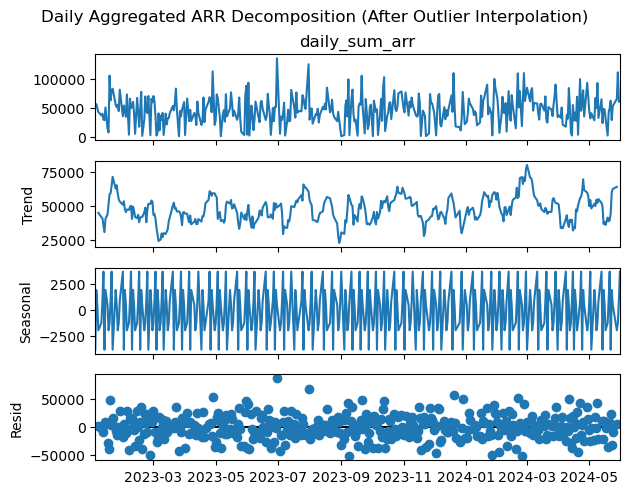

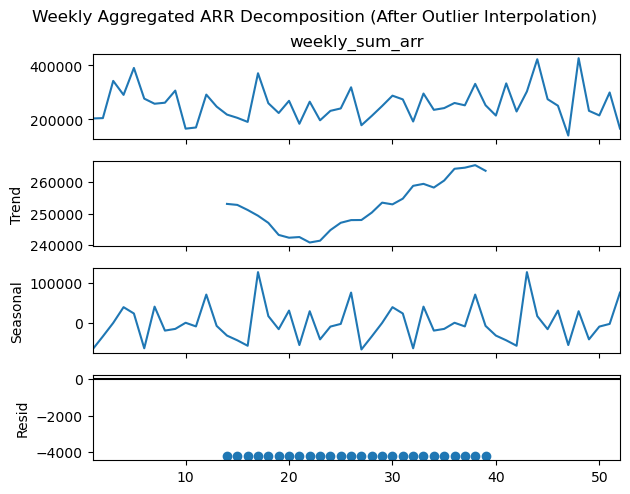

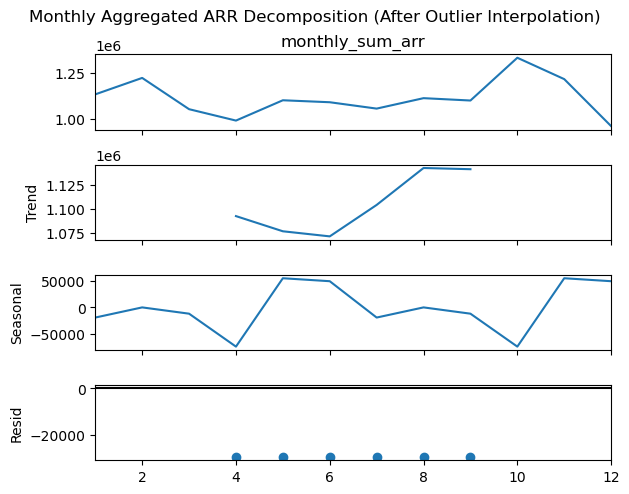

In [11]:
# Re-identify outliers using Z-score for daily, weekly, and monthly data
# Interpolate only the values marked as outliers

# Identify and interpolate outliers for daily data
daily_aggregated['daily_zscore'] = zscore(daily_aggregated['daily_sum_arr'])
daily_aggregated['daily_zscore_outlier'] = daily_aggregated['daily_zscore'].abs() > 3
daily_aggregated['daily_sum_arr'] = daily_aggregated['daily_sum_arr'].mask(daily_aggregated['daily_zscore_outlier']).interpolate()

# Identify and interpolate outliers for weekly data
weekly_aggregated['weekly_zscore'] = zscore(weekly_aggregated['weekly_sum_arr'])
weekly_aggregated['weekly_zscore_outlier'] = weekly_aggregated['weekly_zscore'].abs() > 3
weekly_aggregated['weekly_sum_arr'] = weekly_aggregated['weekly_sum_arr'].mask(weekly_aggregated['weekly_zscore_outlier']).interpolate()

# Identify and interpolate outliers for monthly data
monthly_aggregated['monthly_zscore'] = zscore(monthly_aggregated['monthly_sum_arr'])
monthly_aggregated['monthly_zscore_outlier'] = monthly_aggregated['monthly_zscore'].abs() > 3
monthly_aggregated['monthly_sum_arr'] = monthly_aggregated['monthly_sum_arr'].mask(monthly_aggregated['monthly_zscore_outlier']).interpolate()

# Visualize interpolated data to check changes
# Plot Daily data after interpolation
fig_daily_interpolated = px.line(daily_aggregated, x='Close Date', y='daily_sum_arr', title="Daily Aggregated ARR Over Time (After Outlier Interpolation)",
                                 labels={"Close Date": "Close Date", "daily_sum_arr": "Daily Aggregated Opportunity ARR"})
fig_daily_interpolated.update_layout(xaxis_title="Close Date", yaxis_title="Daily Aggregated Opportunity ARR")
fig_daily_interpolated.show()

# Plot Weekly data after interpolation
fig_weekly_interpolated = px.line(weekly_aggregated, x='week_number', y='weekly_sum_arr', title="Weekly Aggregated ARR Over Time (After Outlier Interpolation)",
                                  labels={"week_number": "Week Number", "weekly_sum_arr": "Weekly Aggregated Opportunity ARR"})
fig_weekly_interpolated.update_layout(xaxis_title="Week Number", yaxis_title="Weekly Aggregated Opportunity ARR")
fig_weekly_interpolated.show()

# Plot Monthly data after interpolation
fig_monthly_interpolated = px.line(monthly_aggregated, x='month_number', y='monthly_sum_arr', title="Monthly Aggregated ARR Over Time (After Outlier Interpolation)",
                                   labels={"month_number": "Month Number", "monthly_sum_arr": "Monthly Aggregated Opportunity ARR"})
fig_monthly_interpolated.update_layout(xaxis_title="Month Number", yaxis_title="Monthly Aggregated Opportunity ARR")
fig_monthly_interpolated.show()

# Daily decomposition
daily_decomposition = seasonal_decompose(daily_aggregated.set_index('Close Date')['daily_sum_arr'], model='additive', period=7)
daily_decomposition.plot()
plt.suptitle("Daily Aggregated ARR Decomposition (After Outlier Interpolation)", y=1.02)
plt.show()

# Weekly decomposition
weekly_decomposition = seasonal_decompose(weekly_aggregated.set_index('week_number')['weekly_sum_arr'], model='additive', period=26)
weekly_decomposition.plot()
plt.suptitle("Weekly Aggregated ARR Decomposition (After Outlier Interpolation)", y=1.02)
plt.show()

# Monthly decomposition
monthly_decomposition = seasonal_decompose(monthly_aggregated.set_index('month_number')['monthly_sum_arr'], model='additive', period=6)
monthly_decomposition.plot()
plt.suptitle("Monthly Aggregated ARR Decomposition (After Outlier Interpolation)", y=1.02)
plt.show()


The ARR data shows distinct seasonal patterns across daily, weekly, and monthly aggregations. On a daily level, the trend is relatively stable with moderate fluctuations, and there is a clear weekly cycle likely tied to operational rhythms, such as higher sales on specific weekdays. Weekly data reveals broader trends with some indications of long-term growth and possible quarterly cycles, driven by business activities like promotions or seasonal demand. Monthly data highlights a steady upward trend, pointing to long-term growth, and shows annual cycles where certain months consistently perform better, possibly due to factors like contract renewals or fiscal schedules. Residual noise decreases with higher levels of aggregation, making patterns clearer at the weekly and monthly levels.

In [12]:
# Create filtered_data with necessary columns for analysis
filtered_data = pipeline_data.dropna(subset=['Billing State/Province', 'Install Subtype', 'Lead Source', 'Opportunity ARR'])

In [13]:
# Group the data by 'Stage'
stage_counts = filtered_data.groupby(['Stage']).size().reset_index(name='Count')
stage_counts['Won/Lost'] = ['Closed Won', 'Closed Won', 'Closed Won', 'Closed Lost', 'Closed Lost']

print(stage_counts)

                         Stage  Count     Won/Lost
0                   Closed Won   4993   Closed Won
1  Closed Won - Add On Product     18   Closed Won
2    Closed Won-Prof. Services     50   Closed Won
3                   No Renewal    495  Closed Lost
4        Stalled Resell Needed    566  Closed Lost


In [14]:
fig = px.histogram(stage_counts, x="Won/Lost", y="Count", color="Stage")
fig.update_layout(width=800, height=600)
fig.show()

In [15]:
# Convert 'Close Date' and 'Created Date' to datetime format, coercing errors to NaT
filtered_data['Close Date'] = pd.to_datetime(filtered_data['Close Date'], errors='coerce')
filtered_data['Created Date'] = pd.to_datetime(filtered_data['Created Date'], errors='coerce')

# Drop rows where date conversion failed for essential columns
filtered_data = filtered_data.dropna(subset=['Close Date', 'Created Date'])


In [16]:
# Divide data into new and existing businesses
new_business_data = filtered_data[filtered_data['Type'] == 'New Business']
existing_business_data = filtered_data[filtered_data['Type'] == 'Existing Business']

# Analyze new vs existing customers

In [17]:
# ARR Summary
new_business_arr_summary = new_business_data['Opportunity ARR'].describe()
existing_business_arr_summary = existing_business_data['Opportunity ARR'].describe()

# Win Rate Calculation
new_business_win_rate = (new_business_data['Stage'] == 'Closed Won').mean()
existing_business_win_rate = (existing_business_data['Stage'] == 'Closed Won').mean()

# Average Deal Closing Time
new_business_data['Closing Time'] = (new_business_data['Close Date'] - new_business_data['Created Date']).dt.days
existing_business_data['Closing Time'] = (existing_business_data['Close Date'] - existing_business_data['Created Date']).dt.days

new_business_avg_closing_time = new_business_data['Closing Time'].mean()
existing_business_avg_closing_time = existing_business_data['Closing Time'].mean()

print("New Business ARR Summary:\n", new_business_arr_summary)
print("Existing Business ARR Summary:\n", existing_business_arr_summary)
print("New Business Win Rate:", new_business_win_rate)
print("Existing Business Win Rate:", existing_business_win_rate)
print("New Business Avg Closing Time:", new_business_avg_closing_time)
print("Existing Business Avg Closing Time:", existing_business_avg_closing_time)

New Business ARR Summary:
 count     3130.000000
mean      3803.103834
std       1983.894350
min          0.000000
25%       3000.000000
50%       3600.000000
75%       4200.000000
max      44500.000000
Name: Opportunity ARR, dtype: float64
Existing Business ARR Summary:
 count     2157.000000
mean      3044.142096
std       1342.751553
min          0.000000
25%       2400.000000
50%       3000.000000
75%       3600.000000
max      37800.000000
Name: Opportunity ARR, dtype: float64
New Business Win Rate: 0.7613418530351438
Existing Business Win Rate: 0.8618451553082985
New Business Avg Closing Time: 23.169009584664536
Existing Business Avg Closing Time: 11.093648585999073


In [18]:
# Plot comparison of opportunity count by type
type_counts = filtered_data['Type'].value_counts()
fig = px.bar(x=type_counts.index, y=type_counts.values, title='Count of Opportunities by Type', labels={'x': 'Type', 'y': 'Count'})
fig.update_layout(width=600, height=300)
fig.show()

In [19]:
# Calculate Average Deal Closing Time for new and existing customers based on 'Close Date'
# Convert 'Created Date' to datetime to calculate deal closing time
new_business_data['Created Date'] = pd.to_datetime(new_business_data['Created Date'])
new_business_data['Closing Time'] = (new_business_data['Close Date'] - new_business_data['Created Date']).dt.days

existing_business_data['Created Date'] = pd.to_datetime(existing_business_data['Created Date'])
existing_business_data['Closing Time'] = (existing_business_data['Close Date'] - existing_business_data['Created Date']).dt.days

new_business_avg_closing_time = new_business_data['Closing Time'].mean()
existing_business_avg_closing_time = existing_business_data['Closing Time'].mean()

print("New Business Average Closing Time (days):", new_business_avg_closing_time)
print("Existing Business Average Closing Time (days):", existing_business_avg_closing_time)

# 4. Trend analysis of ARR over time for new and existing customers based on 'Close Date'
new_business_monthly_arr = new_business_data.groupby(new_business_data['Close Date'].dt.to_period('M'))['Opportunity ARR'].sum()
existing_business_monthly_arr = existing_business_data.groupby(existing_business_data['Close Date'].dt.to_period('M'))['Opportunity ARR'].sum()

# Find the earliest and latest 'Close Date' in the data for setting the x-axis range
earliest_close_date = filtered_data['Close Date'].min().strftime('%Y-%m')
latest_close_date = filtered_data['Close Date'].max().strftime('%Y-%m')

New Business Average Closing Time (days): 23.169009584664536
Existing Business Average Closing Time (days): 11.093648585999073


In [20]:
fig = px.line(existing_business_monthly_arr, x=existing_business_monthly_arr.index.astype(str), y=existing_business_monthly_arr.values, title='Monthly ARR for Existing Business (Close Date)')
fig.update_layout(xaxis_title='Month', yaxis_title='Total ARR', xaxis_range=[earliest_close_date, latest_close_date], width=600, height=400)
fig.show()

In [21]:
fig = px.line(new_business_monthly_arr, x=new_business_monthly_arr.index.astype(str), y=new_business_monthly_arr.values, title='Monthly ARR for New Business (Close Date)')
fig.update_layout(xaxis_title='Month', yaxis_title='Total ARR', xaxis_range=[earliest_close_date, latest_close_date], width=600, height=400)
fig.show()

# Time series analysis of opportunity count and ARR

In [22]:
# Growth of Key Metrics Over Time (Opportunities and ARR)

# Monthly Opportunity Count and ARR
filtered_data['Month'] = filtered_data['Close Date'].dt.to_period('M')
monthly_opportunity_counts = filtered_data.groupby('Month').size()
monthly_arr = filtered_data.groupby('Month')['Opportunity ARR'].sum()

In [23]:
# Plot Monthly Opportunity Counts and ARR Over Time

fig_opportunities = px.line(monthly_opportunity_counts, x=monthly_opportunity_counts.index.astype(str), y=monthly_opportunity_counts.values, title='Monthly Opportunity Counts')
fig_opportunities.update_layout(xaxis_title='Month', yaxis_title='Number of Opportunities')
fig_opportunities.show()

fig_arr = px.line(monthly_arr, x=monthly_arr.index.astype(str), y=monthly_arr.values, title='Monthly ARR Over Time')
fig_arr.update_layout(xaxis_title='Month', yaxis_title='Total ARR')
fig_arr.show()

# Average ARR and win rate by state

In [24]:
# Calculate average ARR and win rate by state
state_summary = filtered_data.groupby('Billing State/Province').agg({
    'Opportunity ARR': 'mean',
    'Stage': lambda x: (x == 'Closed Won').mean()
}).rename(columns={'Opportunity ARR': 'Average ARR', 'Stage': 'Win Rate'})


print("State Summary:\n", state_summary.sort_values('Win Rate', ascending=False).to_string())


State Summary:
                               Average ARR  Win Rate
Billing State/Province                             
Wyoming                       4238.888889  1.000000
Alaska                        4458.250000  1.000000
Quintana Roo                  2075.000000  1.000000
South Australia               2700.000000  1.000000
South Dakota                  3600.000000  1.000000
US Virgin Islands             3366.666667  1.000000
Puerto Rico                   2593.750000  1.000000
Milan                         1980.000000  1.000000
Jalisco                       3000.000000  1.000000
Nova Scotia                   2903.750000  1.000000
Prince Edward Island          3300.000000  1.000000
Baja California Sur           2850.000000  1.000000
West Virginia                 4050.000000  1.000000
Western Australia             2925.000000  1.000000
Mexico State                  6000.000000  1.000000
Wisconsin                     3425.604651  0.930233
Kansas                        3485.185185  0.925

In [25]:
fig_state = px.scatter(state_summary, x='Average ARR', y='Win Rate', title='Average ARR and Win Rate by State')
fig_state.update_layout(xaxis_title='Average ARR', yaxis_title='Win Rate')
fig_state.show()

# Conversion Rate by Lead Source

In [26]:
# Function to classify 'Won/Lost' based on 'Stage' column values
def classify_won_lost(stage):
    if 'Closed Won' in stage:
        return 'Closed Won'
    else:
        return 'Closed Lost'

# Add a new 'Won/Lost' column to the DataFrame based on values in the 'Stage' column
filtered_data['Won/Lost'] = filtered_data['Stage'].apply(classify_won_lost)

# Function to calculate the conversion rate for each lead source
def calculate_conversion_rate(group):
    wins = (group['Won/Lost'] == 'Closed Won').sum()  # Count of 'Closed Won' instances
    total = wins + (group['Won/Lost'] == 'Closed Lost').sum()  # Total count of 'Closed Won' and 'Closed Lost'
    return wins / total if total > 0 else None  # Return the conversion rate

# Create a DataFrame with the conversion rate for each 'Lead Source'
lead_source_conversion = (
    filtered_data.groupby('Lead Source')
    .apply(calculate_conversion_rate)
    .reset_index(name='Conversion Rate')
    .sort_values(by='Conversion Rate', ascending=False)  # Sort by Conversion Rate in descending order
)

# Plot a bar chart to visualize the conversion rate for each lead source
fig = px.bar(lead_source_conversion, x='Lead Source', y='Conversion Rate', title='Conversion Rate by Lead Source')
fig.update_layout(xaxis_title='Lead Source', yaxis_title='Conversion Rate', width=1000, height=600)
fig.show()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[52] intercept   : AIC=inf, Time=6.29 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=174.088, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=178.076, Time=0.62 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=178.618, Time=0.62 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=175.617, Time=0.09 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=176.060, Time=0.27 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=176.060, Time=0.34 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=176.096, Time=0.08 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=178.080, Time=0.10 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=inf, Time=0.36 sec

Best model:  ARIMA(0,0,0)(0,1,0)[52] intercept
Total fit time: 10.677 seconds
Mean Squared Error: 8921391292.821772


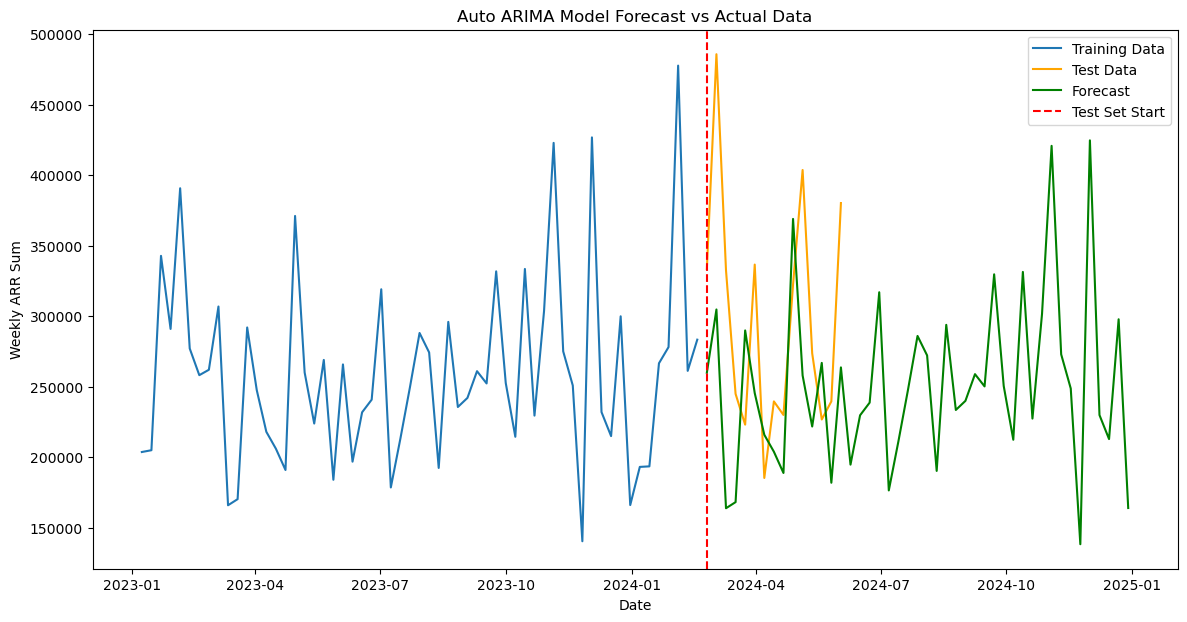

In [27]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

# Convert 'Close Date' column to datetime format, handling errors by coercing to NaT
pipeline_data['Close Date'] = pd.to_datetime(pipeline_data['Close Date'], errors='coerce')

# Remove rows with NaT in 'Close Date'
pipeline_data = pipeline_data.dropna(subset=['Close Date'])

# Group data by weeks and aggregate 'Opportunity ARR' values
weekly_aggregated = pipeline_data.groupby(pd.Grouper(key='Close Date', freq='W'))['Opportunity ARR'].sum().reset_index()

# Set 'Close Date' as the index
weekly_aggregated['Close Date'] = pd.to_datetime(weekly_aggregated['Close Date'])
weekly_aggregated.set_index('Close Date', inplace=True)

# Split data into 80% training and 20% testing sets
train_size = int(len(weekly_aggregated) * 0.8)
train, test = weekly_aggregated.iloc[:train_size], weekly_aggregated.iloc[train_size:]

# Fit auto_arima model on the training data
model = auto_arima(train, seasonal=True, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, m=52)

# Calculate the number of weeks between the test start and end of 2024
last_date = '2024-12-31'
weeks_to_forecast = ((pd.to_datetime(last_date) - test.index[0]).days // 7) + 1

# Forecast for the period from the start of the test set to the end of 2024
forecast = model.predict(n_periods=weeks_to_forecast)

# Calculate Mean Squared Error (MSE) on the test set
mse = mean_squared_error(test[:len(forecast)], forecast[:len(test)])
print(f"Mean Squared Error: {mse}")

# Generate a date range for the forecast from the start of the test set to the end of 2024
forecast_index = pd.date_range(start=test.index[0], periods=weeks_to_forecast, freq='W')

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data', color='orange')
plt.plot(forecast_index, forecast, label='Forecast', color='green')
plt.axvline(x=test.index[0], color='red', linestyle='--', label='Test Set Start')
plt.title('Auto ARIMA Model Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Weekly ARR Sum')
plt.legend()
plt.show()

# Summary of Key Insights

## New vs. Existing Business
- **ARR**: New business opportunities tend to generate higher revenue potential compared to existing customers.
- **Win Rate**: Existing customers have significantly higher win rates, reflecting strong customer retention and loyalty.
- **Closing Time**: Deals with existing customers close much faster than those with new customers, indicating greater efficiency in maintaining existing relationships.

## ARR and Win Rate by State
- There are notable differences in ARR and win rates across states.
- States with high ARR often align with higher win rates, suggesting opportunities for region-specific strategies.
- These insights can inform targeted sales and marketing efforts.

## Conversion Rate by Lead Source
- Conversion rates vary significantly across different lead sources.
- Certain lead sources are more effective in closing deals, making them critical for optimizing marketing and sales investments.
- Focusing on high-performing channels can improve overall efficiency.

## ARR Trends Over Time
- **New Business**: Monthly ARR for new business shows consistent growth with occasional peaks, influenced by seasonality or promotions.
- **Existing Business**: ARR for existing customers is more stable, providing predictable revenue streams.

## Forecasting Full-Year 2024 Revenue
- The Auto ARIMA model indicates steady ARR growth through the end of 2024.
- Seasonal patterns observed in historical data align with forecasted trends, supporting its reliability.

## Next Steps
- Leverage geographic insights to refine region-specific strategies.
- Optimize marketing efforts by prioritizing high-conversion lead sources.
- Gather additional data, such as customer demographics and reasons for deal outcomes, to enhance strategic planning.

In [28]:
# import pandas as pd
# from openpyxl import load_workbook

# # Initialize an Excel writer
# output_path = 'CRM_Pipeline_Summary_with_Definitions.xlsx'
# with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
#    # Sheet 1: ARR trends over time (monthly and weekly aggregates)
#     monthly_summary = arr_over_time.resample('M').sum()[['monthly_sum_arr']].reset_index()
#     monthly_summary.columns = ['Month', 'Monthly Aggregated ARR']
#     weekly_summary = arr_over_time.resample('W').sum()[['weekly_sum_arr']].reset_index()
#     weekly_summary.columns = ['Week', 'Weekly Aggregated ARR']
    
#     monthly_summary.to_excel(writer, sheet_name='ARR Trends', index=False, startrow=2, header=True)
#     weekly_summary.to_excel(writer, sheet_name='ARR Trends', index=False, startcol=4, startrow=2, header=True)
    
#     # Adding Titles
#     workbook  = writer.book
#     worksheet = writer.sheets['ARR Trends']
#     worksheet.cell(row=1, column=1, value='Monthly ARR Trends')
#     worksheet.cell(row=1, column=5, value='Weekly ARR Trends')
    
#     # Sheet 2: Conversion rates by lead source
#     lead_source_conversion.to_excel(writer, sheet_name='Conversion Rates by Lead', index=False)
    
#     # Sheet 3: ARR and win rate by state
#     state_summary.to_excel(writer, sheet_name='ARR and Win Rate by State', index=True)
    
#     # Sheet 4: New vs. Existing Customers Summary
#     new_existing_summary = pd.DataFrame({
#         'Metric': [
#             'New Business ARR Mean', 'Existing Business ARR Mean',
#             'New Business Win Rate', 'Existing Business Win Rate',
#             'New Business Avg Closing Time', 'Existing Business Avg Closing Time'
#         ],
#         'New Business': [
#             new_business_arr_summary['mean'] if 'mean' in new_business_arr_summary else None,
#             None,
#             new_business_win_rate if not pd.isna(new_business_win_rate) else None,
#             None,
#             new_business_avg_closing_time if not pd.isna(new_business_avg_closing_time) else None,
#             None
#         ],
#         'Existing Business': [
#             None,
#             existing_business_arr_summary['mean'] if 'mean' in existing_business_arr_summary else None,
#             None,
#             existing_business_win_rate if not pd.isna(existing_business_win_rate) else None,
#             None,
#             existing_business_avg_closing_time if not pd.isna(existing_business_avg_closing_time) else None
#         ]
#     })
#     new_existing_summary.to_excel(writer, sheet_name='New vs Existing Customers', index=False)
    
#     # Definitions sheet
#     definitions = pd.DataFrame({
#         'Field': [
#             "18 Digit Opportunity ID", "Account ID", "Parent Account ID", 
#             "Created Date", "Last Modified Date", "Close Date", "Type", "Stage", 
#             "Opportunity ARR (Annual Recurring Revenue)", "Billing State/Province", 
#             "Install Subtype", "Lead Source", "Subscription Level Type"
#         ],
#         'Definition': [
#             "A unique identifier for the opportunity in Salesforce, used to track each sales deal. "
#             "Salesforce uses an 18-digit case-insensitive identifier for API access, making it easier to manage unique records.",
            
#             "The unique identifier for the account associated with the opportunity. An account in Salesforce represents "
#             "a company or organization involved in business dealings.",
            
#             "This refers to the unique identifier of the parent account, if the account in question is part of a larger "
#             "corporate hierarchy. This field helps in managing account hierarchies.",
            
#             "The date when the opportunity record was first created in Salesforce. This helps track when the sales opportunity initially entered the pipeline.",
            
#             "The date when the opportunity was last updated. It reflects the most recent change made to the record, whether by a user or an automated process.",
            
#             "The date when the opportunity is expected to close. In sales forecasting, this is a critical date, used to project when the deal is likely to be finalized.",
            
#             "The classification of the opportunity, which may represent different types of sales processes (e.g., New Business, Renewal, Upsell, etc.).",
            
#             "Represents the current step in the sales process for this opportunity. Stages are used to track the progress of the deal, "
#             "such as Prospecting, Negotiation, Closed Won, Closed Lost, etc.",
            
#             "Refers to the total amount of recurring revenue expected from the opportunity on an annual basis. "
#             "This is commonly used for subscription-based products and services to measure the revenue over a year.",
            
#             "The state or province where the billing address for the account is located. This can be important for tax purposes or geographic sales reporting.",
            
#             "A specific categorization of the product or service installation type. This may refer to different implementation options or technical configurations being sold to the customer.",
            
#             "This refers to the origin of the opportunity, such as Marketing Campaign, Web Inquiry, Referral, Cold Call, etc. "
#             "It tracks how the lead first entered the pipeline.",
            
#             "Defines the type or level of subscription being purchased. It may represent different tiers of service or product offerings, such as Basic, Premium, or Enterprise subscription levels."
#         ]
#     })
#     definitions.to_excel(writer, sheet_name='Definitions', index=False)

# output_path

In [ ]:
# !jupyter nbconvert --to script salesforce-pipeline-analysis.ipynb

[NbConvertApp] Converting notebook salesforce-pipeline-analysis.ipynb to script
[NbConvertApp] Writing 38339 bytes to salesforce-pipeline-analysis.py
